# How to Use pyclesperanto_prototype With Dask: Rescaling Images
Here we will take a first look of how to process our images with dask using the zarr file format. Furthermore, we will take a look at the precautions we need to take when using pyclesperanto_prototype functions as well as other functions that cannot deal with images of dimensions > 3. First we will load our data and see the simplest case of processing images:

In [1]:
import dask.array as da
import numpy as np
import pyclesperanto_prototype as cle
from dask_image_procesing_tips_n_tricks import dask_clesperanto_adapter
from skimage.filters import gaussian

# Make sure to select the file location on your machine!
zarr_file = r"C:\Users\ryans\Documents\output data (big)\dask tutorial\lund_zenodo.zarr"
lund_stack = da.from_zarr(url=zarr_file, component="original_data")
lund_stack

,Array,Chunk
Bytes,2.77 GiB,71.00 MiB
Shape,"(40, 71, 1024, 512)","(1, 71, 1024, 512)"
Count,41 Tasks,40 Chunks
Type,uint16,numpy.ndarray


For functions which can handle over three dimensional images processing the stack is really easy using the map blocks function. When dask hands single images to the functions it splits the images of shape (t,z,y,x) into single images of shape (1,z,y,x). Luckily scikit image functions can deal with these images so we can just natively use them with the map blocks function as follows:

In [2]:
%%time

processed_image = da.map_blocks(gaussian, lund_stack, sigma = 5)
processed_image

CPU times: total: 0 ns
Wall time: 2.95 ms


,Array,Chunk
Bytes,11.09 GiB,284.00 MiB
Shape,"(40, 71, 1024, 512)","(1, 71, 1024, 512)"
Count,81 Tasks,40 Chunks
Type,float64,numpy.ndarray


Nothing has been processed yet, hence why we see dask visual representation of the stack instead of an array. To see if the processing worked we need to look at a certain image:

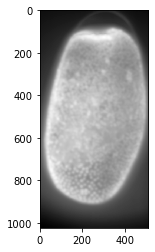

CPU times: total: 4.03 s
Wall time: 4.97 s


In [3]:
%%time
cle.imshow(processed_image[0])

As you can see processing takes quite a bit longer than mapping the function to the blocks. Now if we want to use clesperanto functions we need to hand it images of the shape (z, y, x) and afterward turn it back into an image of the shape (1, z, y, x). Talley Lambert wrote a function which does this in his [notebook](https://github.com/tlambert03/napari-dask-example/blob/8e41a78b7415ee9e3d4867c68ae3d93314bf1307/dask_napari.ipynb). I have slightly modified the code he wrote there to make a wrapper for clesperanto functions which does this for all images in the arguments (args) and keyword arguments (kwargs) called `dask_clesperanto_adapter`. Here is what the code looks like:
```python
@curry
def dask_clesperanto_adapter(function):

    @wraps(function)
    def worker_function(*args, **kwargs):
        new_args = []
        new_kwargs = {}
        extras = []
        for arg in args:
            if is_image(arg):
                if arg.ndim >3:
                    modified_array = np.squeeze(arg[...,:,:,:]) 
                    extras.append(arg.ndim - modified_array.ndim)
                    new_args.append(modified_array)
                    continue
            new_args.append(arg)
                    
        for key,value in kwargs.items():    
            if is_image(value):
                if value.ndim >3:
                    modified_array = np.squeeze(value[...,:,:,:]) 
                    extras.append(value.ndim - modified_array.ndim)
                    new_kwargs[key] = modified_array
                    continue
            new_kwargs[key] = value
        
        new_args = tuple(new_args)
        result = cle.pull(function(*new_args, **new_kwargs))
        if extras:
            for i in range(min(extras)):
                result = result[None, ...]
        return result
    
    return worker_function
```
What the function does is that it goes through all images in the arguments and keyword arguments and tries to find images with more than three dimensions. It will then remove the higher dimensions, keeping in mind how many were removed. The returned image is also pulled from GPU memory and the extra dimensions are added to the array again, since dask expects the output image to be the same dimensionality as the stack.

To use the resampling function from pyclesperanto_prototype, we must first see what the shape and dtype of the rescaling will look like. If the shape doesn't change when applying the function then you can ignore it. You usually know the dtype if you have used the functions before, but it can't hurt taking a peek!

In [4]:
dask_rescaling = dask_clesperanto_adapter(cle.resample)

voxel_size_zyx = np.array([3.0,0.6934,0.6934])
norm_voxel_size = voxel_size_zyx/0.6934
print(norm_voxel_size)

sample = dask_rescaling(
    lund_stack[0], 
    factor_z = norm_voxel_size[0],
    factor_y = norm_voxel_size[1],
    factor_x = norm_voxel_size[2],
)
print(f"shape: {sample.shape}")
print(f"dtype: {sample.dtype}")

[4.32650707 1.         1.        ]
shape: (307, 1024, 512)
dtype: float32


Now we can apply the function to our dask stack with the map_blocks function, making sure we set the output chunk size and the dtype:

In [5]:
rescaled = da.map_blocks(
    dask_rescaling, 
    lund_stack, 
    factor_z = norm_voxel_size[0],
    factor_y = norm_voxel_size[1],
    factor_x = norm_voxel_size[2],
    dtype = "float32",
    chunks=(1, 307, 1024, 512)
)
rescaled

,Array,Chunk
Bytes,23.98 GiB,614.00 MiB
Shape,"(40, 307, 1024, 512)","(1, 307, 1024, 512)"
Count,81 Tasks,40 Chunks
Type,float32,numpy.ndarray


To save this processed stack to disk for later use we can again use zarr and add another component for the rescaled data. We will also create a dask client with only one worker to ensure that our GPU memory does not overflow:

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1) 
client = Client(cluster)

C:\Users\ryans\Anaconda3\envs\np_workflows_v1\envs\dask-testing\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54984 instead
  warnings.warn(


In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:54984/status,
Dashboard: http://127.0.0.1:54984/status,Workers: 1
Total threads: 8,Total memory: 23.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54985,Workers: 1
Dashboard: http://127.0.0.1:54984/status,Total threads: 8
Started: Just now,Total memory: 23.71 GiB
Comm: tcp://127.0.0.1:54995,Total threads: 8
Dashboard: http://127.0.0.1:54996/status,Memory: 23.71 GiB
Nanny: tcp://127.0.0.1:54988,


If you visit the URL in the dashboard field you can check out what is happening on your machine and how dask distributes the tasks, which can be helpful for troubleshooting!

In [8]:
da.to_zarr(arr=rescaled,
    # Make sure to select the file location on your machine!
    url = r"C:\Users\ryans\Documents\output data (big)\dask tutorial\lund_zenodo.zarr", 
    component="rescaled_data", 
    overwrite=True, 
    compute=True,
    compressor = None
)

When opening a client like we just did, we also need to close it at the end of the session so it doesn't keep running in the background!

In [13]:
client.shutdown()

2022-07-08 15:54:41,600 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
